In [1]:
from google.colab import drive
drive.mount ('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!ls '/content/gdrive/MyDrive/DR_model'

best_model					       train
cnn-hyperparameter-tuning.ipynb			       train2
diabetic-retinopathy-with-resnet50-oversampling.ipynb  trainLabels.csv
Inception-diabetic_retinopathy.ipynb


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib.pyplot as plt
from subprocess import check_output
from numpy import savez_compressed

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import regularizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

#list the files in the input directory
#print(os.listdir("../input"))
#print(check_output(["ls", "../input"]).decode("utf8")) #trainLabels.csv
#print(check_output(["pwd", ""]).decode("utf8")) # /kaggle/working/
#classes : 0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

In [4]:
labels = {0:"No DR", 1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

In [5]:
NUM_CLASSES = 5
# we need images of same size so we convert them into the size
WIDTH = 224
HEIGHT = 224
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)

# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
#global variables
ImageNameDataHash = {}
uniquePatientIDList = []

In [6]:
def readTrainData(trainDir):
    global ImageNameDataHash
    # loop over the input images
    images = os.listdir(trainDir)
    print("Number of files in " + trainDir + " is " + str(len(images)))
    for imageFileName in images:
        if (imageFileName == "trainLabels.csv"):
            continue
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(os.path.sep, trainDir, imageFileName)
        #print(imageFullPath)
        img = load_img(imageFullPath)
        arr = img_to_array(img) 
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        #print(dim1)
        #print(dim2)
        #print(dim3)
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
        #print(arr.shape) # 256,256,3
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
            print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
        #print(type(arr))
        # scale the raw pixel intensities to the range [0, 1] - TBD TEST
        arr = np.array(arr, dtype="float") / 255.0
        imageFileName = imageFileName.replace('.jpeg','')
        ImageNameDataHash[str(imageFileName)] = np.array(arr) 
      
    return

In [8]:
#csv contains image	level
#10_left 0
#10_right 0
import csv
def readTrainCsv():
    raw_df = pd.read_csv('/content/gdrive/My Drive/DR_model/trainLabels.csv', sep=',')
    print(type(raw_df)) #<class 'pandas.core.frame.DataFrame'>
    row_count=raw_df.shape[0] #gives number of row count row_count=35126 
    col_count=raw_df.shape[1] #gives number of col count col count=2
    print("row_count="+str(row_count)+" col count="+str(col_count))
    raw_df["PatientID"] = ''
    header_list = list(raw_df.columns)
    print(header_list) # ['image', 'level', 'PatientID']
    # double check if level of left and right are same or not
    ImageLevelHash = {}
    patientIDList = []
    for index, row in raw_df.iterrows():
        # 0 is image, 1 is level, 2 is PatientID, 3 is data
        key = row[0] + ''
        patientID = row[0] + ''
        patientID = patientID.replace('_right','')
        patientID = patientID.replace('_left','')
        #print("Adding patient ID"+ patientID)
        raw_df.at[index, 'PatientID'] = patientID
        patientIDList.append(patientID)
        ImageLevelHash[key] = str(row[1]) # level
                
    global uniquePatientIDList
    uniquePatientIDList = sorted(set(patientIDList))
    count=0;
    for patientID in uniquePatientIDList:
        left_level = ImageLevelHash[str(patientID+'_left')]
        right_level = ImageLevelHash[str(patientID+'_right')]
        #right_exists = str(patientID+'_right') in raw_df.values
        if (left_level != right_level):
            count = count+1
            #print("Warning for patient="+ str(patientID) + " left_level=" + left_level+ " right_level=" +right_level)
    print("count of images with both left and right eye level not matching="+str(count)) # 2240
    print("number of unique patients="+str(len(uniquePatientIDList))) # 17563
    return raw_df

In [9]:
random.seed(10)
print("Reading trainLabels.csv...")
df = readTrainCsv()

Reading trainLabels.csv...
<class 'pandas.core.frame.DataFrame'>
row_count=35126 col count=2
['image', 'level', 'PatientID']
count of images with both left and right eye level not matching=2240
number of unique patients=17563


In [10]:
for i in range(0,10):
    s = df.loc[df.index[i], 'PatientID'] # get patient id of patients
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=10
1 patient's patientID=10
2 patient's patientID=13
3 patient's patientID=13
4 patient's patientID=15
5 patient's patientID=15
6 patient's patientID=16
7 patient's patientID=16
8 patient's patientID=17
9 patient's patientID=17


In [11]:
# df has 3 columns ['image', 'level', 'PatientID']
keepImages =  list(ImageNameDataHash.keys())
df = df[df['image'].isin(keepImages)]
print(len(df)) # 1000

3302


In [12]:
#convert hash to dataframe
imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key])) # np.array

df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr})
df2_header_list = list(df2.columns) 
print(df2_header_list) # ['image', 'data']
print(len(df2)) # 1000
#print(df2.describe(include='all'))
#print(df2.sample(3)) # 3 rows x 2 columns

['image', 'data']
3302


In [13]:
if len(df) != len(df2):
    print("Error length of df != df2")
    
for idx in range(0,len(df)):
    if (df.loc[df.index[idx], 'image'] != df2.loc[df2.index[idx], 'image']):
        print("Error " + df.loc[df.index[idx], 'image'] +"==" + df2.loc[df2.index[idx], 'image'])
        
print(df2.dtypes)
print(df.dtypes)

image    object
data     object
dtype: object
image        object
level         int64
PatientID    object
dtype: object


In [14]:
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer')
df_header_list = list(df.columns) 
print(df_header_list) # 'image', 'data', level', 'PatientID'
print(len(df)) # 1000
print(df.sample())
#print(df)

['image', 'data', 'level', 'PatientID']
3302
            image  ... PatientID
2356  29228_right  ...     29228

[1 rows x 4 columns]


In [15]:
unique, counts = np.unique(df['level'], return_counts=True)
dict(zip(unique, counts))

{0: 2405, 1: 243, 2: 497, 3: 80, 4: 77}

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
<class 'numpy.ndarray'>
(224, 224, 3)


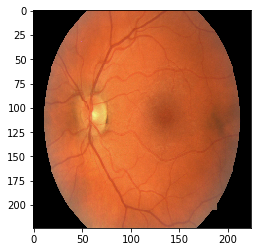

Sample Image


In [16]:
sample0 = df.loc[df.index[0], 'data']
print(sample0)
print(type(sample0)) # <class 'numpy.ndarray'>
print(sample0.shape) # 128,128,3
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("Sample Image")

In [17]:
X = df['data']
Y = df['level']
# scale the raw pixel intensities to the range [0, 1]
#print(type(X)) # 'pandas.core.series.Series'
#X = np.array(X, dtype="float") / 255.0 -- TBD moved to top
Y = np.array(Y)
# convert the labels from integers to vectors
Y =  to_categorical(Y, num_classes=NUM_CLASSES)

In [18]:
# partition the data into training and testing splits using 75% training and 25% for validation
print("Parttition data into 75:15:15...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique())) # 500
unique_ids = df.PatientID.unique()
print('unique_ids shape='+ str(len(unique_ids))) #500

# Refer https://www.kaggle.com/kmader/tf-data-tutorial-with-retina-and-keras
train2_ids, test_ids = train_test_split(unique_ids, test_size = 0.15, random_state = 10) #stratify = rr_df['level'])


train_ids, valid_ids = train_test_split(train2_ids, test_size = 0.15, random_state = 10) #stratify = rr_df['level'])
trainid_list = train_ids.tolist()
print('trainid_list shape=', str(len(trainid_list))) # 375

traindf = df[df.PatientID.isin(trainid_list)]
testdf =  df[~df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

Parttition data into 75:15:15...
Unique patients in dataframe df=1652
unique_ids shape=1652
trainid_list shape= 1193


In [19]:
print(traindf.head())
print(testdf.head())
print(valSet.head())



traindf = traindf.reset_index(drop=True)
testdf = testdf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

print(len(traindf))
print(len(testdf))
print(len(valSet))

      image                                               data  level PatientID
0   30_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      1        30
1  30_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      2        30
4   33_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        33
5  33_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        33
8   84_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        84
       image  ... PatientID
2    31_left  ...        31
3   31_right  ...        31
6    36_left  ...        36
7   36_right  ...        36
10   95_left  ...        95

[5 rows x 4 columns]
       image  ... PatientID
2    31_left  ...        31
3   31_right  ...        31
6    36_left  ...        36
7   36_right  ...        36
10   95_left  ...        95

[5 rows x 4 columns]
2385
917
917


In [20]:
trainX = traindf['data']
trainY = traindf['level']

testX = testdf['data']
testY = testdf['level']

valX = valSet['data']
valY = valSet['level']

#(trainX, valX, trainY, valY) = train_test_split(X,Y,test_size=0.25, random_state=10)
print('trainX shape=', trainX.shape[0], 'testX shape=', testX.shape[0], 'valX shape=', valX.shape[0]) # 750, 250

trainX shape= 2385 testX shape= 917 valX shape= 917


In [21]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
testY =  to_categorical(testY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)
print(valY)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [22]:
testX[0].shape

(224, 224, 3)

In [23]:
#construct the image generator for data augmentation
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [24]:
base_model = VGG16(weights="imagenet", include_top=False,input_shape=inputShape)
base_model.trainable = False ## Not trainable weights

from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


58900480/58889256 [==============================] - 0s 0us/step


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                1254450   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
Total params: 15,970,263
Trainable params: 1,255,575
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
opt = 'rmsprop'
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
print("Reshaping trainX at..."+ str(datetime.now()))
#print(trainX.sample()) 
print(type(trainX)) # <class 'pandas.core.series.Series'>
print(trainX.shape) # (750,)
from numpy import zeros
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]): # 0 to traindf Size -1
    Xtrain[i] = trainX[i]
print(Xtrain.shape) # (750,128,128,3)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2021-10-30 08:38:12.853288
<class 'pandas.core.series.Series'>
(2385,)
(2385, 128, 128, 3)
Reshaped trainX at...2021-10-30 08:38:16.067474


In [27]:
print("Reshaping testX at..."+ str(datetime.now()))
print(testX.shape) 
print(type(testX)) # <class 'pandas.core.series.Series'>
print(testX.shape) # (750,)
from numpy import zeros
Xtest = np.zeros([testX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(testX.shape[0]): # 0 to traindf Size -1
    Xtest[i] = testX[i]
print(Xtest.shape) # (750,128,128,3)
print("Reshaped testX at..."+ str(datetime.now()))

Reshaping testX at...2021-11-01 12:31:51.761930
(917,)
<class 'pandas.core.series.Series'>
(917,)
(917, 224, 224, 3)
Reshaped testX at...2021-11-01 12:31:52.834924


In [ ]:
print("Reshaping valX at..."+ str(datetime.now()))
print(type(valX)) # <class 'pandas.core.series.Series'>
print(valX.shape) # (250,)
from numpy import zeros
Xval = np.zeros([valX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(valX.shape[0]): # 0 to traindf Size -1
    Xval[i] = valX[i]
print(Xval.shape) # (250,128,128,3)
print("Reshaped valX at..."+ str(datetime.now()))

Reshaping valX at...2021-11-01 12:31:56.020585
<class 'pandas.core.series.Series'>
(917,)


In [ ]:
Xtrain = preprocess_input(Xtrain)
Xval = preprocess_input(Xval)
Xtest = preprocess_input(Xtest)

In [ ]:
path = 'modelpath'

In [ ]:
# train the network
print("training network...")
sys.stdout.flush()
#class_mode ='categorical', # 2D one-hot encoded labels

H = model.fit(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1)
# save the model to disk
print("Saving model to disk")
sys.stdout.flush()
model.save(path)


Generating plots...


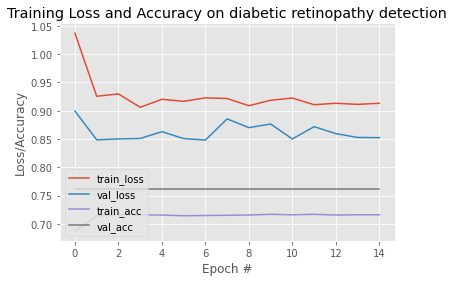

In [ ]:
import matplotlib
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
score = model.evaluate(Xtest, testY, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1.5440173149108887
Test accuracy: 0.05343511328101158


In [ ]:
predict_x=model.predict(Xtest) 
print(predict_x)
classes_x=np.argmax(predict_x,axis=1)
#classes_x

[[0.22943969 0.54361176 0.10322331 0.04372473 0.08000048]
 [0.23439401 0.5419434  0.10207231 0.04149581 0.08009449]
 [0.27678254 0.50623596 0.10008547 0.04137615 0.07551986]
 ...
 [0.28144795 0.53761286 0.08122824 0.03425913 0.06545187]
 [0.27559245 0.49916288 0.10905498 0.04383969 0.07234999]
 [0.2597533  0.5419615  0.09386255 0.04390321 0.06051951]]


The scikit-learn metrics API expects a 1D array of actual and predicted values for comparison, therefore, we must reduce the 2D prediction arrays to 1D arrays.



In [ ]:
# reduce to 1d array
predict_x = predict_x[:,0]
classes_x = classes_x[:]

We are now ready to calculate metrics for our deep learning neural network model. We can start by calculating the classification accuracy, precision, recall, and F1 scores.

In [ ]:
test_classes = np.argmax(testY, axis =1)
test_classes

array([0, 0, 1, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 4, 2, 4, 4, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 4, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1,
       2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0,

In [ ]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_classes, classes_x)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_classes, classes_x, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_classes, classes_x, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_classes, classes_x, average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.053435
Precision: 0.053435
Recall: 0.053435
F1 score: 0.053435
